# Dependencies 

In [1]:
from sys import path
path.append('src/')

import cv2
import numpy as np
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skmultilearn.model_selection import iterative_train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_VAL_DUMP = 'data/val_dump.pkl'

FILE_MODEL = 'models/best_model.hdf5'

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

# Data Loading 

In [4]:
_, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))
y_train = np.array([mrk_file.photo_reqs.values() for mrk_file in train_mrks])

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

(5211, 224, 224, 3) float32
(5211, 23) int32


In [50]:
_, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))
y_val = np.array([mrk_file.photo_reqs.values() for mrk_file in val_mrks])

print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(571, 224, 224, 3) float32
(571, 23) int32


In [5]:
x = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

print(x.shape, y.shape)

(5782, 224, 224, 3) (5782, 23)


In [6]:
np.random.seed(42)
x_train, y_train, x_val, y_val = iterative_train_test_split(x, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5188, 224, 224, 3) (5188, 23)
(594, 224, 224, 3) (594, 23)


In [7]:
pkl.dump((x_train, x_val), open('data/autoencoder_samples.pkl', 'wb'), -1)

# Model Training 

In [4]:
x_train, x_val = pkl.load(open('data/autoencoder_samples.pkl', 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5188, 224, 224, 3) float32 0.0 1.0
(594, 224, 224, 3) float32 0.0 1.0


In [5]:
def conv_bn(idx, prev_input, filters, name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = 'relu_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation('relu', name=act_name)(conv)
    return conv

def conv_bn_maxpool(idx, prev_input,  filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool

def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 32)      128       
__________

5188/5188 [==============================] - 16s 3ms/step - loss: 0.0025 - val_loss: 0.0029TA: 6s - loss:  - ETA: 6s - loss: - ETA: 5s - loss: 0.0 - ETA: 5s -  - ETA: 1s - ETA: 0s - loss:

Epoch 00014: val_loss did not improve from 0.00253
Epoch 15/50
5188/5188 [==============================] - 16s 3ms/step - loss: 0.0026 - val_loss: 0.0039loss: 0.002 - ETA: 2s - loss: 0. - ETA: 1s - loss: 0.0 - ETA: 1s - loss:  - ETA: 1s - 

Epoch 00015: val_loss did not improve from 0.00253
Epoch 16/50
5188/5188 [==============================] - 16s 3ms/step - loss: 0.0027 - val_loss: 0.0029.00 

Epoch 00016: val_loss did not improve from 0.00253
Epoch 17/50
5188/5188 [==============================] - 16s 3ms/step - loss: 0.0025 - val_loss: 0.00274s - - ETA: 3s

Epoch 00017: val_loss did not improve from 0.00253
Epoch 18/50
5188/5188 [==============================] - 16s 3ms/step - loss: 0.0026 - val_loss: 0.00241s - loss: - ETA: 0s - lo

Epoch 00018: val_loss improved from 0.00253 to 0.00238, sa

5188/5188 [==============================] - 16s 3ms/step - loss: 0.0019 - val_loss: 0.00212 - ETA: 11 - E - ETA: 7s - loss: 0.00 - ETA:  - ETA: 6s - los - ETA: 5s - loss: 0.00 - ETA: 5s - lo - ETA: 4s - loss: 0.001 - ETA - ETA: 2s - ETA: 0s - loss: 0.00 - ETA: 0s - los

Epoch 00044: val_loss did not improve from 0.00172
Epoch 45/50
5188/5188 [==============================] - 16s 3ms/step - loss: 0.0018 - val_loss: 0.00262s - loss - ETA: 8 - ETA: 6s - loss: 0. - E - ETA: - ETA: 2s - loss: 0.0 - ETA: 0s - loss: 0.0

Epoch 00045: val_loss did not improve from 0.00172
Epoch 00045: early stopping


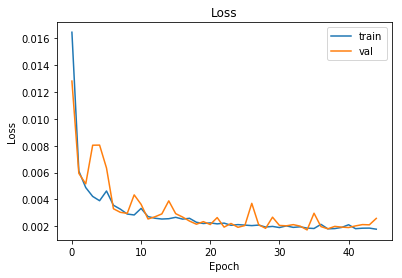

In [6]:
inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 16)
pool_2 = conv_bn_maxpool(2, pool_1, 32)
pool_3 = conv_bn_maxpool(3, pool_2, 64)
pool_4 = conv_bn_maxpool(4, pool_3, 128)
encode = conv_bn(5, pool_4, 256, name='encoded')

dec_4 = deconv_bn(4, encode, 128)
dec_3 = deconv_bn(3, dec_4, 64)
dec_2 = deconv_bn(2, dec_3, 32)
dec_1 = deconv_bn(1, dec_2, 16)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

model = Model(inputs=inputs, outputs=decoded)
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

list_callbacks = [ModelCheckpoint(FILE_MODEL, monitor='val_loss', verbose=1, save_best_only=True), 
                  EarlyStopping(monitor='val_loss', patience=10, verbose=1)]

hist = model.fit(x_train, x_train, batch_size=32, epochs=50, validation_data=(x_val, x_val), callbacks=list_callbacks)
plot_loss(hist)

In [7]:
model = load_model(FILE_MODEL)
y_pred = model.predict(x_val)

print(y_pred.shape, y_pred.dtype, y_pred.min(), y_pred.max())

(594, 224, 224, 3) float32 0.009936719 0.99999595


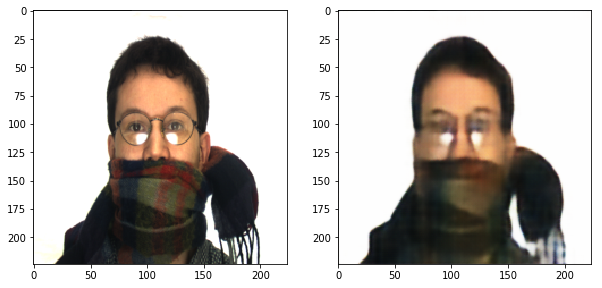

In [9]:
n_images = x_val.shape[0]
index = np.random.choice(range(n_images))

im_orig = x_val[index]
im_pred = y_pred[index]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(im_orig[:, :, ::-1])

plt.subplot(1, 2, 2)
plt.imshow(im_pred[:, :, ::-1])

# Embeddings Visualization 

In [5]:
from tensorflow.contrib.tensorboard.plugins import projector
from os.path import basename

In [16]:
metadata_file = open('logs/metadata.tsv', 'w')
for file in range(x_val.shape[0]):
    metadata_file.write('image_{}.png\n'.format(file))
metadata_file.close()

In [7]:
model = load_model(FILE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 32)      128       
__________

In [8]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [9]:
im_sprite = images_to_sprite(x_val)
print(im_sprite.shape)

cv2.imwrite('logs/sprites.png', im_sprite)

(5600, 5600, 3)


True

In [11]:
emb_vectors = model_emb.predict(x_val)
print(emb_vectors.shape)

(594, 256)


In [14]:
with tf.Session() as sess:
    tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
    summary_writer = tf.summary.FileWriter('logs')

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = tf_embeddings.name
    embedding.metadata_path = 'metadata.tsv'
    embedding.sprite.image_path = 'sprites.png'
    embedding.sprite.single_image_dim.extend([224, 224])

    projector.visualize_embeddings(summary_writer, config)
    
    saver = tf.train.Saver([tf_embeddings])
    sess.run(tf_embeddings.initializer)
    saver.save(sess, 'logs/embeddings.ckpt')